## Set up

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import sys
import glob
import math
import torch
import pickle as pkl
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
sys.path.append("/n/home12/binxuwang/Github/Neuro-ActMax-GAN-comparison")

In [3]:
tabdir = r"/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_Project/Stats_tables"
meta_df = pd.read_csv(join(tabdir, "meta_activation_stats_w_optimizer.csv"), index_col=0)

In [4]:
meta_df.shape

(170, 49)

### Distance and Plot functions

In [5]:
# compute mahalanobis distance
def mahalanobis_sqdist(x, mean, eigvec, eigval, eigfloor=1e-5, device="cuda"):
    x = x.to(device) - mean[None, :].to(device)
    # rotate
    rot_x = x @ eigvec
    # scale
    return (rot_x ** 2 / torch.clamp(eigval[None, :].to(device), min=eigfloor)).sum(dim=1)


# plot functions to collect activation / distace according to gens. 
def compute_mean_var(x, gen_vec, var="std"):
    meanvec = []
    errvec = []
    for gen in range(gen_vec.min(), gen_vec.max()+1):
        meanvec.append(x[gen_vec==gen].mean())
        if var == "std":
            errvec.append(x[gen_vec==gen].std())
        elif var == "var":
            errvec.append(x[gen_vec==gen].var())
        elif var == "sem":
            errvec.append(x[gen_vec==gen].std() / np.sqrt((gen_vec==gen).sum()))
    return torch.tensor(meanvec), torch.tensor(errvec)


def plot_shaded_errorbar(x, y, color="b", label="", var="std", **kwargs):
    meanvec, errvec = compute_mean_var(y, x, var=var)
    plt.plot(np.unique(x), meanvec, color=color, label=label, **kwargs)
    plt.fill_between(np.unique(x), meanvec-errvec, meanvec+errvec, color=color, alpha=0.3)

In [6]:
def gaussian_nll_with_eig(x, mean, eigvals, eigvecs, eigfloor=1E-3, device="cuda"):
    """
    Calculate the Gaussian negative log likelihood of x given the mean, eigenvalues, and eigenvectors.

    Args:
        x (torch.Tensor): Input tensor of shape (batch_size, input_dim).
        mean (torch.Tensor): Mean tensor of shape (input_dim,).
        eigvals (torch.Tensor): Eigenvalues tensor of shape (input_dim,).
        eigvecs (torch.Tensor): Eigenvectors tensor of shape (input_dim, input_dim).

    Returns:
        torch.Tensor: Gaussian negative log likelihood tensor of shape (batch_size,).
    """
    input_dim = x.size(1)
    diff = x - mean
    eigvals_clamped = torch.clamp(eigvals.to(device), min=eigfloor)
    mahalanobis = torch.matmul(diff, eigvecs)
    mahalanobis = mahalanobis**2 / eigvals_clamped
    mahalanobis = torch.sum(mahalanobis, dim=1)
    log_det = torch.sum(torch.log(eigvals_clamped))
    nll = 0.5 * (input_dim * math.log(2 * math.pi) + log_det + mahalanobis)
    return nll


In [6]:
def dist2k_nearest_neighbor_w_index(probe_embed, ref_embed, k_list, device="cuda"):
    """
    Calculate the Euclidean distance between a probe embedding and the k nearest neighbors in a reference embedding.

    Args:
        probe_embed (torch.Tensor): Embedding tensor of shape (probe_size, embedding_dim).
        ref_embed (torch.Tensor): Reference embedding tensor of shape (ref_size, embedding_dim).
        k_list (list): List of integers specifying the number of nearest neighbors to consider.
        device (str): Device to perform the calculations on (default is "cuda").

    Returns:
        dict: Dictionary containing the distances to the k nearest neighbors for each probe embedding.
    """
    probe_embed = probe_embed.to(device)
    ref_embed = ref_embed.to(device)
    dists = torch.cdist(probe_embed, ref_embed,
                            p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary')
    max_k = max(k_list)
    k_nearest, indices = torch.topk(dists, max_k, largest=False, dim=-1)
    distances = {}
    for k in k_list:
        distances[k] = k_nearest[:, k-1]
    return distances, indices


In [7]:
def dist2k_nearest_neighbor_mahalanobis_w_index(probe_embed, ref_embed, k_list, eigvecs, eigvals, eigfloor=1E-3, device="cuda"):
    """
    Calculate the Euclidean distance between a probe embedding and the k nearest neighbors in a reference embedding.

    Args:
        probe_embed (torch.Tensor): Embedding tensor of shape (probe_size, embedding_dim).
        ref_embed (torch.Tensor): Reference embedding tensor of shape (ref_size, embedding_dim).
        k_list (list): List of integers specifying the number of nearest neighbors to consider.
        device (str): Device to perform the calculations on (default is "cuda").

    Returns:
        dict: Dictionary containing the distances to the k nearest neighbors for each probe embedding.
    """
    probe_embed = probe_embed.to(device)
    ref_embed = ref_embed.to(device)
    scaling = torch.sqrt(torch.clamp(eigvals.to(device), min=eigfloor))
    probe_embed_rot = (probe_embed @ eigvecs) / scaling
    ref_embed_rot = (ref_embed @ eigvecs) / scaling
    dists = torch.cdist(probe_embed_rot, ref_embed_rot,
                            p=2.0, compute_mode='use_mm_for_euclid_dist_if_necessary')
    max_k = max(k_list)
    k_nearest, indices = torch.topk(dists, max_k, largest=False, dim=-1)
    distances = {}
    for k in k_list:
        distances[k] = k_nearest[:, k-1]
    return distances, indices


In [8]:
def dist2k_nearest_neighbor_cosine_w_index(probe_embed, ref_embed, k_list, device="cuda"):
    """
    Calculate the 1 - Cosine Similarity distance between a probe embedding and the k nearest neighbors in a reference embedding.

    Args:
        probe_embed (torch.Tensor): Embedding tensor of shape (probe_size, embedding_dim).
        ref_embed (torch.Tensor): Reference embedding tensor of shape (ref_size, embedding_dim).
        k_list (list): List of integers specifying the number of nearest neighbors to consider.
        device (str): Device to perform the calculations on (default is "cuda").

    Returns:
        dict: Dictionary containing the distances to the k nearest neighbors for each probe embedding.
    """
    probe_embed = probe_embed.to(device)
    ref_embed = ref_embed.to(device)
    similarity = torch.matmul(probe_embed, ref_embed.T)
    similarity = similarity / torch.norm(probe_embed, dim=1)[:, None]
    similarity = similarity / torch.norm(ref_embed, dim=1)[None, :]
    dists = 1 - similarity
    max_k = max(k_list)
    k_nearest, indices = torch.topk(dists, max_k, largest=False, dim=-1)
    distances = {}
    for k in k_list:
        distances[k] = k_nearest[:, k-1]
    return distances, indices


### Compute Reference Dataset PC structure

In [9]:
GANembed_root = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/GAN_img_embedding"
GANembed_dir = join(GANembed_root, "dinov2_vitb14")
Evol_embed_dir = '/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_img_embedding/dinov2_vitb14'

def load_compute_eigen(dataset_str):
    if dataset_str == "imagenet_valid":
        embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    else:
        _, embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    embed = embed.cuda()
    cov = torch.cov(embed.T, )
    data_mean = embed.mean(dim=0)
    data_eigvals, data_eigvecs = torch.linalg.eigh(cov)
    data_eigvals = torch.flip(data_eigvals, dims=[0])
    data_eigvecs = torch.flip(data_eigvecs, dims=[1])
    return (data_mean, data_eigvals, data_eigvecs)

def load_dataset_embed(dataset_str):
    if dataset_str == "imagenet_valid":
        embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    else:
        _, embed = pkl.load(open(join(GANembed_dir, dataset_str+"_embedding.pkl"), "rb"))
    return embed

In [10]:
# FC_mean, FC_eigvals, FC_eigvecs = load_compute_eigen("DeePSim_4std")
# BG_mean, BG_eigvals, BG_eigvecs = load_compute_eigen("BigGAN_trunc07")
# BGRND_mean, BGRND_eigvals, BGRND_eigvecs = load_compute_eigen("BigGAN_std_008")
# IN_mean, IN_eigvals, IN_eigvecs = load_compute_eigen("imagenet_valid")
MH_eig_col = {}
for dataset_str in [
    "DeePSim_4std",
    "BigGAN_trunc07",
    "BigGAN_std_008",
    "imagenet_valid",
    'ecoset_val',
    'places365_val',
    'massmem_objects',
    'curvature_contour',
    "pink_noise",
]:
    MH_eig_col[dataset_str] = load_compute_eigen(dataset_str)

In [11]:
dataset_embed_col = {}
for dataset_str in [
    "DeePSim_4std",
    "BigGAN_trunc07",
    "BigGAN_std_008",
    "imagenet_valid",
    'ecoset_val',
    'places365_val',
    'massmem_objects',
    'curvature_contour',
    "pink_noise",
]:
    dataset_embed_col[dataset_str] = load_dataset_embed(dataset_str).cuda()

In [12]:
for dataset_str, dataset_embed in dataset_embed_col.items():
    print(f"Number of rows in {dataset_str}: {dataset_embed.shape[0]}")


Number of rows in DeePSim_4std: 50000
Number of rows in BigGAN_trunc07: 50000
Number of rows in BigGAN_std_008: 50000
Number of rows in imagenet_valid: 50000
Number of rows in ecoset_val: 28250
Number of rows in places365_val: 36500
Number of rows in massmem_objects: 2400
Number of rows in curvature_contour: 2960
Number of rows in pink_noise: 50000


### ImageNet Validation set labels straight

### Loading and visualizing labels of ImageNet 1000k

In [17]:
import platform
from core.utils.dataset_utils import ImageDataset_filter
from core.utils.dataset_utils import create_imagenet_valid_dataset
from core.utils.dataset_utils import ImageDataset_filter, denormalizer
from torch.utils.data import DataLoader
rootdir = r"/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Datasets/imagenet-valid"
INdataset = create_imagenet_valid_dataset(imgpix=224,rootdir=rootdir)
# dataloaders = DataLoader(INdataset, batch_size=256, shuffle=False, num_workers=8)

Note the label in this default dataset is wrong.

In [17]:
# get first 20 labels
labels = [INdataset[i][1] for i in range(200)]
print(labels)


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


* Issue of using this file `ILSVRC2012_validation_ground_truth.txt` `https://stackoverflow.com/questions/42537483/ilsvrc2012-validation-ground-truth-labels-index-not-matching-pretrained-networks`
* So we should use this aligned `val.txt` from the `https://github.com/BVLC/caffe/blob/master/data/ilsvrc12/get_ilsvrc_aux.sh` script. 

In [29]:
# ground_truth_file = os.path.join(rootdir, 'ILSVRC2012_validation_ground_truth.txt')
# with open(ground_truth_file, 'r') as file:
#     valset_labels = [int(line.strip()) for line in file]

# print(len(valset_labels))
# print(valset_labels[-1]) # 186 
# print(np.max(valset_labels))
# print(np.min(valset_labels))

50000


In [14]:
vallabel_dict = {}
with open(os.path.join(rootdir, 'val.txt'), 'r') as file:
    for line in file:
        key, value = line.strip().split()
        vallabel_dict[key] = int(value)

vallabel_list = [vallabel_dict[os.path.basename(INdataset.samples[i][0])] for i in range(len(INdataset))]

In [15]:
import ast
with open(join(rootdir, 'imagenet_class_description_index.txt'), 'r') as file:
    # Read the contents of the file
    file_contents = file.read()
    # Convert the string to a dictionary
    label_descr_dict = ast.literal_eval(file_contents)

In [16]:
import json
with open(join(rootdir, 'imagenet_class_index.json'), 'r') as file:
    label_dict = json.load(file)
label_dict = {int(key): value[1] for key, value in label_dict.items()}

-----------------
sea_snake
sea snake


/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


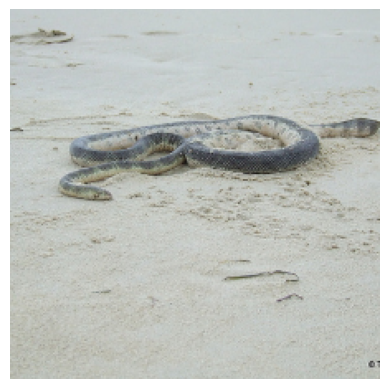

-----------------
alp
alp


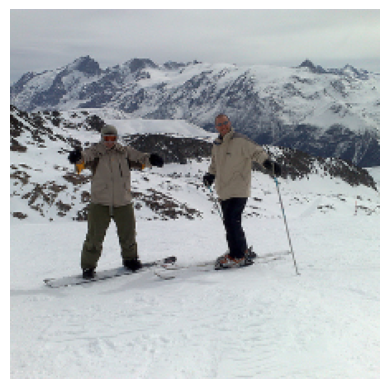

-----------------
Shetland_sheepdog
Shetland sheepdog, Shetland sheep dog, Shetland


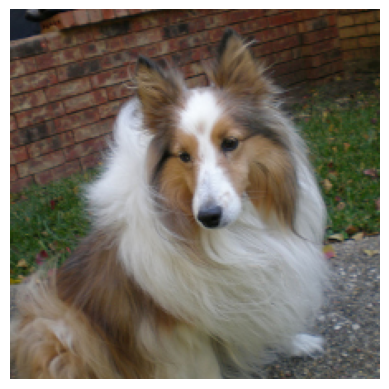

-----------------
soup_bowl
soup bowl


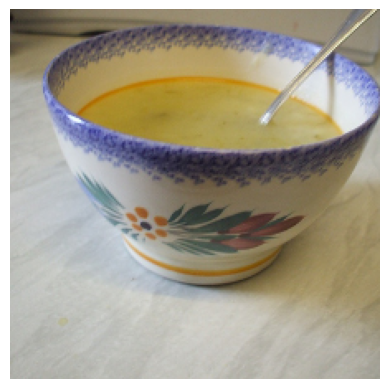

-----------------
cradle
cradle


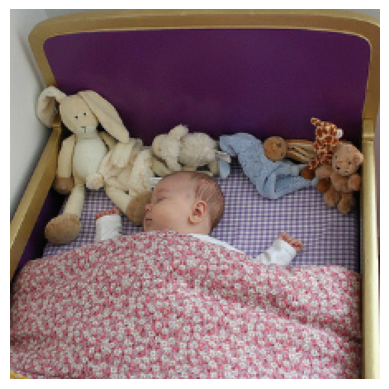

-----------------
garter_snake
garter snake, grass snake


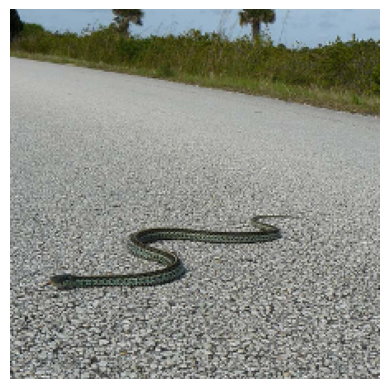

-----------------
porcupine
porcupine, hedgehog


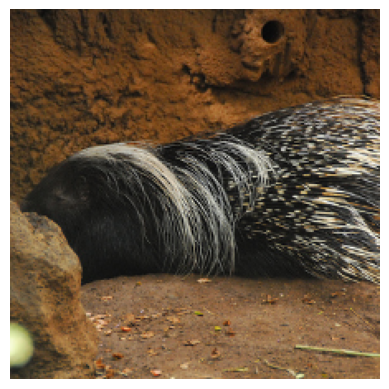

-----------------
bakery
bakery, bakeshop, bakehouse


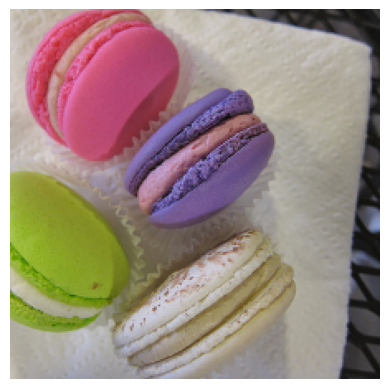

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


-----------------
mousetrap
mousetrap


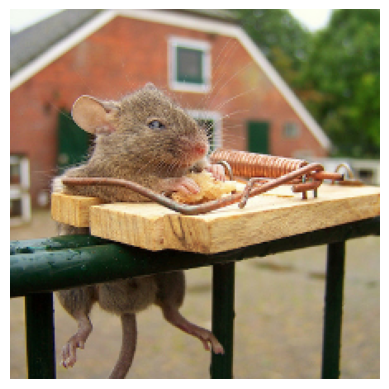

-----------------
Angora
Angora, Angora rabbit


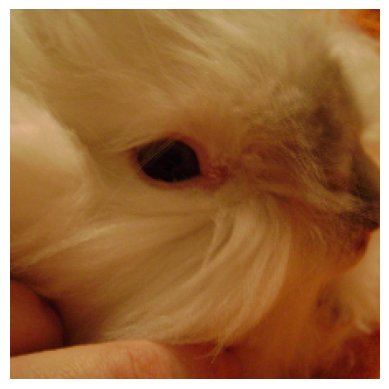

In [18]:
for i in range(10):
    imgfn = os.path.basename(INdataset.samples[i][0])
    # imgfn = INdataset.samples[i][0].split('/')[-1]
    print('-----------------')
    print(label_dict[vallabel_dict[imgfn]])
    print(label_descr_dict[vallabel_dict[imgfn]])
    plt.imshow(denormalizer(INdataset[i][0]).permute(1,2,0))    
    plt.axis('off')
    plt.show()

### kNN and their labels

In [31]:
# compute mahalanobis distance for all Exps
stats_df_col = []
for Expi in tqdm(range(1, 190+1)):
    # if ~ os.path.exists(join(Evol_embed_dir, f"Exp{Expi}_embed_act_data.pkl")):
    #     continue
    if Expi not in meta_df.index:
        continue
    meta_dict = meta_df.loc[Expi][['Animal', 'expdate', 'ephysFN', 'prefchan', 'prefunit', 'visual_area',
       'space1', 'space2', 'optim_names1', 'optim_names2', 'blockN']].to_dict()
    Evol_data = pkl.load(open(join(Evol_embed_dir, f"Exp{Expi:03d}_embed_act_data.pkl"), "rb"))
    for thread in [0, 1]:
        stats_col = {}
        embeddings = Evol_data[f"embeddings{thread}"].cuda()
        gen_vec = Evol_data[f"gen_vec{thread}"]
        resp_mat = Evol_data[f"resp_mat{thread}"]
        stats_col["Expi"] = Expi
        stats_col["thread"] = thread
        stats_col["generation"] = gen_vec
        stats_col["resp_mean"] = resp_mat[:, 0]
        for dataset_str in ["imagenet_valid"]: #MH_eig_col:
            data_mean, data_eigvals, data_eigvecs = MH_eig_col[dataset_str]
            dataset_embed = dataset_embed_col[dataset_str]
            # MHdist_thread = mahalanobis_sqdist(embeddings, data_mean, data_eigvecs, data_eigvals, eigfloor=1e-3).cpu()
            # NLL_thread = gaussian_nll_with_eig(embeddings, data_mean, data_eigvals, data_eigvecs, eigfloor=1e-3).cpu()
            kNNdist, kNN_idxs = dist2k_nearest_neighbor_w_index(embeddings, dataset_embed, k_list=[1, 5, 10, 25, 50])
            KNNMHdist, KNNMH_idxs = dist2k_nearest_neighbor_mahalanobis_w_index(embeddings, dataset_embed, [1, 5, 10, 25, 50],
                                                            data_eigvecs, data_eigvals, eigfloor=1e-3)
            kNNcosdist, kNNcos_idxs = dist2k_nearest_neighbor_cosine_w_index(embeddings, dataset_embed, [1, 5, 10, 25, 50])
            # stats_col[f"MHdist_{dataset_str}"] = MHdist_thread
            # stats_col[f"NLL_{dataset_str}"] = NLL_thread
            for k in kNNdist:
                stats_col[f"kNNdist_{k}_{dataset_str}"] = kNNdist[k].cpu()
                stats_col[f"kNNMHdist_{k}_{dataset_str}"] = KNNMHdist[k].cpu()
                stats_col[f"kNNcosdist_{k}_{dataset_str}"] = kNNcosdist[k].cpu()
            for i in range(50):
                stats_col[f"kNNidx_{i}_{dataset_str}"] = kNN_idxs[:, i].cpu()
                stats_col[f"kNNMHidx_{i}_{dataset_str}"] = KNNMH_idxs[:, i].cpu()
                stats_col[f"kNNcosidx_{i}_{dataset_str}"] = kNNcos_idxs[:, i].cpu()
        stats_col.update(meta_dict)
        stats_df = pd.DataFrame(stats_col)
        stats_df_col.append(stats_df)

stats_df_all = pd.concat(stats_df_col, ignore_index=True)

100%|██████████| 190/190 [00:10<00:00, 17.32it/s]


In [32]:
stats_df_all.to_csv(join(tabdir, "Evol_img_DINO_embed_kNN_indices.csv"))

In [33]:
stats_df_all.shape

(306052, 180)

In [34]:
dataset_str = "imagenet_valid"
kNNidxs_df = stats_df_all[[f"kNNcosidx_{i}_{dataset_str}" for i in range(50)]].map(lambda x: vallabel_list[x])
kNNidxs_df.columns = [f"kNNcoslabel_{i}_{dataset_str}" for i in range(50)]

In [35]:
stats_df_all = pd.concat([stats_df_all, kNNidxs_df], axis=1)

In [37]:
stats_df_all.to_csv(join(tabdir, "Evol_img_DINO_embed_kNN_indices_labels.csv"))

In [36]:
stats_df_all

,Expi,thread,generation,resp_mean,kNNdist_1_imagenet_valid,kNNMHdist_1_imagenet_valid,kNNcosdist_1_imagenet_valid,kNNdist_5_imagenet_valid,kNNMHdist_5_imagenet_valid,kNNcosdist_5_imagenet_valid,...,kNNcoslabel_40_imagenet_valid,kNNcoslabel_41_imagenet_valid,kNNcoslabel_42_imagenet_valid,kNNcoslabel_43_imagenet_valid,kNNcoslabel_44_imagenet_valid,kNNcoslabel_45_imagenet_valid,kNNcoslabel_46_imagenet_valid,kNNcoslabel_47_imagenet_valid,kNNcoslabel_48_imagenet_valid,kNNcoslabel_49_imagenet_valid
0,3,0,1,159.850917,49.656757,33.299236,0.702477,51.799873,33.556297,0.713107,...,189,192,861,904,917,182,192,192,182,452
1,3,0,1,105.139166,48.584103,34.233967,0.678336,50.716000,34.993610,0.722378,...,314,773,921,6,696,960,916,446,611,667
2,3,0,1,114.781936,44.129807,30.893002,0.629351,45.854916,31.348623,0.679475,...,740,424,842,613,893,424,916,655,843,917
3,3,0,1,113.217269,42.653053,29.840944,0.567292,44.982975,30.611311,0.613542,...,585,865,620,539,917,808,456,524,921,916
4,3,0,1,204.278660,50.152756,32.329895,0.654570,51.948975,33.660084,0.711423,...,917,588,181,850,921,452,689,200,332,354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306047,190,1,19,270.388398,49.362324,31.321207,0.637685,51.034004,32.571178,0.688971,...,674,771,648,827,740,726,592,753,691,868
306048,190,1,19,371.792224,49.694767,33.045734,0.674464,51.500195,33.263763,0.708565,...,490,499,788,4,461,502,490,777,502,795
306049,190,1,19,364.520691,51.622890,33.341549,0.673014,52.508247,34.433956,0.725043,...,788,584,921,502,714,421,788,770,854,778
306050,190,1,19,314.235970,44.556786,29.780348,0.502738,49.823704,32.530197,0.594464,...,691,485,785,785,785,511,785,785,785,836


In [54]:
init_gen_mask  = (stats_df_all.generation > 1) & \
                 (stats_df_all.generation <= 5)
final_gen_mask = (stats_df_all.generation >= stats_df_all.blockN - 5) & \
                 (stats_df_all.generation <= stats_df_all.blockN - 1)
BigGAN_mask = stats_df_all.thread == 1
IT_mask = stats_df_all.visual_area == "IT"
V4_mask = stats_df_all.visual_area == "V4"

In [41]:
stats_df_all[init_gen_mask][["kNNcoslabel_1_imagenet_valid"]].\
    value_counts()#.unstack(fill_value=0)

kNNcoslabel_1_imagenet_valid  kNNcoslabel_2_imagenet_valid
917                           917                             1412
                              921                              903
921                           917                              724
917                           539                              385
                              916                              373
                                                              ... 
468                           892                                1
469                           61                                 1
                              306                                1
                              467                                1
1                             1                                  1
Name: count, Length: 14490, dtype: int64

In [55]:
knn_coslabels_init = stats_df_all[init_gen_mask & BigGAN_mask & IT_mask][[f"kNNcoslabel_{i}_imagenet_valid" 
                                             for i in range(50)]].to_numpy()
knn_coslabels_end = stats_df_all[final_gen_mask & BigGAN_mask & IT_mask][[f"kNNcoslabel_{i}_imagenet_valid" 
                                             for i in range(50)]].to_numpy()

In [56]:
labels_init, counts_init = np.unique(knn_coslabels_init, return_counts=True)
labels_end, counts_end = np.unique(knn_coslabels_end, return_counts=True)

In [57]:
def print_labels_counts(labels, counts, label_dict=label_descr_dict, topk=30):
    sorted_indices = np.argsort(-counts)
    sorted_labels = labels[sorted_indices]
    sorted_counts = counts[sorted_indices]
    for label, count in zip(sorted_labels[:topk], sorted_counts[:topk]):
        label_name = label_dict[label]
        print(f"{label_name}: {count}")


In [60]:
print_labels_counts(labels_init, counts_init, label_dict=label_dict, topk=30)

Mexican hairless: 10865
Border terrier: 7591
malinois: 5873
wallaby, brush kangaroo: 5605
comic book: 5440
Irish terrier: 5389
seat belt, seatbelt: 5371
hog, pig, grunter, squealer, Sus scrofa: 4872
butcher shop, meat market: 4758
grey fox, gray fox, Urocyon cinereoargenteus: 4525
book jacket, dust cover, dust jacket, dust wrapper: 4441
mask: 4384
Airedale, Airedale terrier: 4313
German shepherd, German shepherd dog, German police dog, alsatian: 4093
standard schnauzer: 3942
sea lion: 3817
miniature pinscher: 3746
hatchet: 3646
punching bag, punch bag, punching ball, punchball: 3626
dhole, Cuon alpinus: 3490
sombrero: 3477
wild boar, boar, Sus scrofa: 3382
Australian terrier: 3338
armadillo: 3281
Lakeland terrier: 3254
miniature schnauzer: 3244
wire-haired fox terrier: 3224
vizsla, Hungarian pointer: 3173
Weimaraner: 3163
Rhodesian ridgeback: 3134


In [58]:
print_labels_counts(labels_end, counts_end, label_dict=label_dict, topk=30)

Pekinese, Pekingese, Peke: 10894
wild boar, boar, Sus scrofa: 9258
black-footed ferret, ferret, Mustela nigripes: 7436
wombat: 7074
red fox, Vulpes vulpes: 6707
hog, pig, grunter, squealer, Sus scrofa: 6349
polecat, fitch, foulmart, foumart, Mustela putorius: 6250
beaver: 5547
kit fox, Vulpes macrotis: 5463
Border terrier: 5317
armadillo: 5112
Chihuahua: 4917
chiton, coat-of-mail shell, sea cradle, polyplacophore: 4897
Japanese spaniel: 4668
brown bear, bruin, Ursus arctos: 4557
Arctic fox, white fox, Alopex lagopus: 4490
American black bear, black bear, Ursus americanus, Euarctos americanus: 4351
comic book: 4256
Pomeranian: 4164
grey fox, gray fox, Urocyon cinereoargenteus: 4159
mongoose: 4120
weasel: 3964
trilobite: 3951
otter: 3899
butcher shop, meat market: 3767
wallaby, brush kangaroo: 3757
Yorkshire terrier: 3703
Australian terrier: 3685
Mexican hairless: 3644
rhinoceros beetle: 3580


In [48]:
label_dict = label_descr_dict
sorted_indices = np.argsort(-counts_init)
sorted_labels = labels_init[sorted_indices]
sorted_counts = counts_init[sorted_indices]

for label, count in zip(sorted_labels[:30], sorted_counts[:30]):
    label_name = label_dict[label]
    print(f"{label_name}: {count}")

comic book: 164725
book jacket, dust cover, dust jacket, dust wrapper: 132870
web site, website, internet site, site: 75045
shower curtain: 32544
jigsaw puzzle: 29650
mask: 29037
doormat, welcome mat: 24758
miniskirt, mini: 23411
envelope: 21114
feather boa, boa: 20361
paintbrush: 19334
tray: 19051
knee pad: 18490
vase: 18136
plastic bag: 17867
binder, ring-binder: 16186
sombrero: 14475
sunglass: 14122
velvet: 13882
Mexican hairless: 13716
loupe, jeweler's loupe: 12483
electric ray, crampfish, numbfish, torpedo: 12343
nipple: 11834
toilet seat: 11830
umbrella: 11752
gasmask, respirator, gas helmet: 11620
hair spray: 11551
saltshaker, salt shaker: 10411
seat belt, seatbelt: 10255
butcher shop, meat market: 10146
